# CA4015 - Assignment 1 – Random Forest and AutoML

This assignment was carried out to better understand how machine learning models are trained using *Sci-kit learn* and the relative ease that this same task can be carried out using AutoML, such as the *PyCaret* library. 

The [Pima Indians diabetes](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database?select=diabetes.csv) dataset used for this assignment comes from Kaggle. To summarise the description on Kaggle, the objective of the dataset is to predict whenever a patient has diabetes or not from certain attributes provided in the dataset. All patients are female, over the age of 21 and of Pima Indian heritage.

This assignment will be broken down into the following 4 sections:

### Section 1 - Setup and data preprocessing
- 1.1 - Importing packages
- 1.2 - Reading in the dataset
- 1.3 - Exploring the data
- 1.4 - Relating back to diabetes causes

### Section 2 - Creating a Random Forest
- 2.1 - Splitting data
- 2.2 - Default Random Forest
- 2.3 - Grid Search
- 2.4 - Boosting
- 2.5 - Results and comparison

### Section 3 - Using PyCaret
- 3.1 - Running PyCaret model generation
- 3.2 - PyCaret results

### Section 4 - Conclusion
- 4.1 - Manual model creation vs. AutoML methods
---

#### The GitHub repo for this project can be found [here](https://github.com/teg-lad/CA4015-diabetes-classification)

---

### Section 1.1 - Importing packages

Below is a list of all the packages that I am inporting for this notebook and a short note on the use of said package.

---

*RandomForestClassifier* - The random forest classifier from sci-kit learn.

*AdaBoostClassifier, GradientBoostingClassifier, DecisionTreeClassifier* - Boosting methods and decision tree to create a boosted random forest.

*cross_val_score* - Cross validation to test how generalizable a model is.

*train_test_split* - Split the data into a train and test set.

*GridSearchCV* - Grid search method to find the optimal parameters for a model.

*accuracy_score, confusion_matrix, classification_report, f1_score, make_scorer* - Some functions for evaluation.

*pandas* - for dataframes and data wrangling.

*scatter_matrix* - For use on the dataframe to get a scatter plot for every pair of attributes.

*pycaret* - AutoML library for finding the ideal model for a machine learning problem.

*mean, std* - To compute the mean and std of the data to find outliers.

*unique* - To get the counts of classes.


In [1]:
# Import all of the required packages.

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, make_scorer
import pandas as pd
from pandas.plotting import scatter_matrix
from pycaret.classification import *
from numpy import mean, std, unique

### Section 1.2 - Reading in the dataset

I'm starting by reading in the dataset from a csv saved locally that I downloaded from the [Kaggle page](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database?select=diabetes.csv). This is done using the Pandas read_csv function with a path to the csv as shown below.

I then call the head() method on the dataframe to make sure it has been read in correctly and to get an idea of the columns.

In [2]:
# Read the dataset in from local disk.

diabetes = pd.read_csv(r"C:\Users\adamt\notebooks\ca4015\diabetes.csv")# Change to the link to download to use directly

# Get all of the column headers and save to the "columns" variable
columns = diabetes.columns

# Output head() and the column names to sanity check the data was read in correctly.
print(diabetes.head())
print(columns)

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')


### Section 1.3 - Exploring the data


With the dataset now loaded it is time to explore the data a little before throwing it at the random forest. To explore the data I am going to make use of some pandas methods to get some different views of the data. These together will hopefully give me a good idea of how values are distributed, correlated and highlight any outliers.

The methods I will use are:

- info()
- describe()
- hist()

---

### dataframe.info()

This method returns a table with the column names of the dataframe as rows along the table. There is a count of non-null values which is useful to quickly spot if any values are nulls. The data type of each column is also listed in the table.



In [3]:
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


It can be seen from above that we have no null values in the dataset and we have primarily integers and a couple of float columns. This means we don't need to worry about nulls or using a method such as integer or one-hot encoding to deal with categorical data.

### dataframe.describe()

The describe() method gives some high-level statistics of the different attributes such as mean, standard deviation, min and max values, median and quartile values. This can quickly give you an idea of how the data is distributed within the different features in the dataset.

In [4]:
diabetes.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Some interesting things I can see from the above:

**Pregnancies**: Quite skewed to the right with a possibility of having some outliers at the right tail.

**Glucose**: Reasonably normal distribution. There seems to be erroneois entries with values of 0. This doesn't make sense to my knowledge and the reasearch I have done. I think it may be best to either correct these with the mean value or possibly even just drop the records if they may confuse the model.

**BloodPressure**: Reasonably normal distribution. This feature is the diatolic blood pressure, which is apparently the least reliable form of blood pressure measurement, the other being mean blood pressure and systolic blood pressure. This to mean seems like it may be an error with the sensor reading the blood pressure.

**SkinThickness**: Quite skewed to the right. This had a minimum of 0 and a max of 99. The former seems like an issue with rounding possibly as there are a lot of values at that low value. The latter is definitely an outlier and possibly an artefact.

**Insulin**: Quite skewed to the right. It seems that there is the possibility of artefacts on both sides of the distribution. It doesn't seem like an insulin level of zero makes sense, so these seem like artefacts. The max value seems to be an outlier.

**BMI**: Reasonably normal distribution. There seems to be BMI values of 0 which make no sense and may need to be addressed.

**DiabetesPedigreeFunction**: Skewed to the right. Seems to be some very high values at the max end, may need to consider these when preprocessing.

**Age**: Skewed to the right. It seems that we have a much greater representation of younger people than of older. This can be seen through the median age of 29 and the upper quartile of 41 with the max age being 81.

---

It can be seen from all of these insights from the describe method that although we don't have null values we may have some artefacts that need to be addressed or at least considered before passing this data to our random forest classifer.

### dataframe.hist()

The hist() method produces a histogram for each of the features in the dataset which shows the distribution of all the values. This can help to highlight any outliers and give a visual representation of the distribution of the feature.

array([[<AxesSubplot:title={'center':'Pregnancies'}>,
        <AxesSubplot:title={'center':'Glucose'}>,
        <AxesSubplot:title={'center':'BloodPressure'}>],
       [<AxesSubplot:title={'center':'SkinThickness'}>,
        <AxesSubplot:title={'center':'Insulin'}>,
        <AxesSubplot:title={'center':'BMI'}>],
       [<AxesSubplot:title={'center':'DiabetesPedigreeFunction'}>,
        <AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'Outcome'}>]], dtype=object)

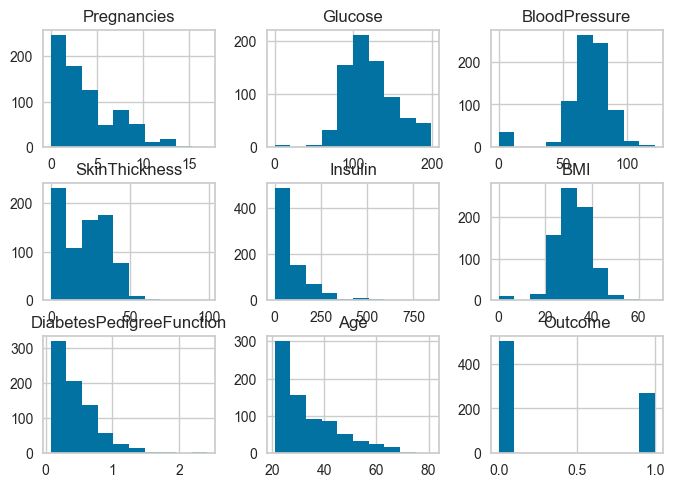

In [5]:
diabetes.hist()

The observations we made using the describe() method are backed up here by the hist method. So now we have to consider if we need to take action against these outliers or artefacts.

---

### What to do now?

Luckily, decision trees are robust against outliers due to the nature of their classification rules. They build these rules to partition the data into the most pure sub-groups possible. This means that the exact value of an attribute isn't important, just whether it is less than or greater than the rule that determines the groupings. This translates well to random forest.

However, it is good practice to inspect the quality of the data, clean and process to ensure we have the data in the right format to ensure the best results. So I will looks specifically at finding and fixing aretefacts within the data. There is no need to consider scaling as the decision trees that random forests consist of will work the same with or without the values normalized.

I have decided to find and fix these artefacts as they can cause confusion within the model due to the values being incorrect readings or values filled with zeroes. Outliers are not of concern, but having these values at zero considered will confuse the model on these features. An example being people with a BMI of zero. We know that this is shouldn't be a genuine value as BMI is calculated as shown below.

$$ BMI = {Weight(kg) \over Height(m)^2} $$

So it can be seen a weight of 0 kilograms is needed to have a BMI of zero. We know this to be impossible for a person, so we can safely assume this is an incorrect value and will lead to confusion within out model. So I will find the mean of this attribute and impute the artefacts with this value to have a better representation of the value.

### Assessing the artefacts within the data

The approach I am taking here is to take the mean of a feature and the standard deviation. Using this we can find data points that are quite far from the mean. In this case I am choosing 3 standard deviation. This is because with ample data and an assumption that the data is roughly normal, we can assume that roughly 99.7% of the data sits within 3 standard deviations of the mean. Values outside of this will be considered outliers.

For our usecase I am just going to review these values and determine if they appear to be artefacts. If they are I will replace them with the mean of the feature. I could instead drop the instance but in this way I can hopefully make use of as much data as possible.

In [6]:
# Dictionary to save the values outside 3 standard deviations of the mean.
possible_artefacts = {}

# For each column in the diabetes datafrome.
for column in diabetes.columns:
    
    # Get all the values
    data = diabetes[column].values
    
    # calculate the mean and standrad deviation of these values.
    data_mean, data_std = mean(data), std(data)
    
    # Find the distance between the mean and 3 standard deviations. Then compute the range this covers.
    cut_off = data_std * 3
    lower, upper = data_mean - cut_off, data_mean + cut_off
    
    print(column + ":", lower, "- " + str(upper))
    
    # Find the values under and over this range.
    lower = set(diabetes[diabetes[column] < lower].index.tolist())
    upper = set(diabetes[diabetes[column] > upper].index.tolist())
    
    # Get the set of all of these indexes and save it.
    current = upper.union(lower)
    possible_artefacts[column] = current
    
    print(diabetes.iloc[list(current)])
    print("-------------------------------------------------------------")
    

Pregnancies: -6.257098753893652 - 13.94720292056032
     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
88            15      136             70             32      110  37.1   
298           14      100             78             25      184  36.6   
455           14      175             62             30        0  33.6   
159           17      163             72             41      114  40.9   

     DiabetesPedigreeFunction  Age  Outcome  
88                      0.153   43        1  
298                     0.412   46        1  
455                     0.212   38        1  
159                     0.817   47        1  
-------------------------------------------------------------
Glucose: 25.039143525391836 - 216.74991897460816
     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
342            1        0             68             35        0  32.0   
182            1        0             74             20       23  27.7   
502           

### Results of artefact search

We will look at each feature individually and assess whether it is just an outlier or an artefact.

**Pregnancies**: The values outside of the range were 14, 14, 15 and 17 pregnancies. These are not absurdly high numbers, nulls or zeroes. This leads me to believe they are genuine outliers and not artefacts, so I will not touch these.

**Glucose**: There are 5 instances with a glucose level of zero. This seems strange to me as the lower limit of the range is 25. I'm unsure of what unit this is measured in, regardless this seems to be an outlier that is also, suspiciously, zero. This leads me to believe that this has been imputed as zero due to no reading being taken. So I will replace these zeroes.

**BloodPressure**: There are a lot of zeroes for blood pressure. As mentioned, distolic blood pressure is apparently the least reliable measurement and this leads me to believe that there was an error with these measurements, as a blood pressure of nothing doesn't seem to quite add up. So I will replace these values with the mean.

**SkinThickness**: The only value outside the range was 99. Which seems absurdly high, so I believe these may be an artefact. I won't remove or replace this as the value itself is not important, just that it is on the upper end of the distribution. There are many zeroes for this feature which I believe may be the result of rounding, although I'm unsure.

**Insulin**: These values all seem to be outliers, but none that seem suspicious in terms of the value entered. So I will ignore these.

**BMI**: Some of the BMI values are outliers, there are also many values recorded as zero. This, as already mentioned, is not a possibility and leads me to believe this was input in place of nulls. So I will replace these values with the mean of the attribute.

**DiabetesPedigreeFunction**: There are a lot of values over the upper limit of the DiabetesPedigreeFunction. These don't seem to be artefacts and can be consider outliers and ignored.

**Age**: There are some outliers in age, but these don't seem to be artefacts and so can be ignored.

*So to summarise, we will replace the zero values in Glucose, BloodPressure and BMI with the mean value for those features.*

In [7]:
# The columsn that we want to replace zero values with the mean
to_reaplace_with_mean = ["Glucose", "BloodPressure", "BMI"]

# For each column.
for column in to_reaplace_with_mean:
    
    # Replace the zero values with the mean
    diabetes[column].replace(to_replace=0, value=diabetes[column].mean(), inplace=True)

    # Print out the rows that we previously highlighted
    print("New values for", column + ":")
    print(diabetes.iloc[list(possible_artefacts[column])])
    print("--------------------------------------------------------------")

New values for Glucose:
     Pregnancies     Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
342            1  120.894531             68             35        0  32.0   
182            1  120.894531             74             20       23  27.7   
502            6  120.894531             68             41        0  39.0   
75             1  120.894531             48             20        0  24.7   
349            5  120.894531             80             32        0  41.0   

     DiabetesPedigreeFunction  Age  Outcome  
342                     0.389   22        0  
182                     0.299   21        0  
502                     0.727   41        1  
75                      0.140   22        0  
349                     0.346   37        1  
--------------------------------------------------------------
New values for BloodPressure:
     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
643            4     90.0      69.105469              0        0  28.0

We can see that worked as expected and we now have dealt with the values that we were unsure of. This should hopefully be a better representation of the real world data that was captured and lead to better results in the model.

### Section 1.4 - Relating back to diabetes causes

Before jumping right in and creating a model it may be worth looking at the causes of diabetes and relating this back to the features we have to understand if they are the features we will need to predict the target value we want, in this case whether or not an individual has diabetes.

Diabetes is a health condition that affects how your body converts food into energy. Food you eat is broken down into glucose which is then released into your bloodstream. Glucose levels in your blood signal your pancreas to create insulin which is needed for this glucose to pass into the cells in your body and be converted to energy. Diabetic people have issues with producing or using insulin effectively. Type 1 diabetes is an autoimmune reaction of the body where the white blood cells attack the islet cells in the pancreas which produce insulin, leading to a low level of insulin. Type 2 diabetes occurs when your body can't effectively use the insulin it has due to many factors.

**Using this information let us see if we can relate any of our features to the causes of diabetes.**

+ Glucose levels are an indication of how much glucose is in a person's blood. If this is at a high level it means that the glucose is not being moved to the cells within the body and can be in indication of insulin resistance. This can put pressure on the pancreas to make more insulin until the demands can't be met and glucose levels rise. This means that glucose levels are at least partially correlated with diabetes 

+ BMI is also an important feature as a persons BMI being higher indicates they are closer to being overweight for their height. People who are not physically active or are overweight or even possibly obese can develop an insulin resistance. This as we know can lead to diabetes so we can say that BMI should be correlated with diabetes.

+ Age is a factor as the older someone gets typically they become less active and develop an insulin resistance. Their pancreas may become less functional with age. So this should mean that age correlates with diabetes.

+ During pregnancy, women can get gestational diabetes due to the changes taking place in their body. This typically goes away after pregancy, but can increase the chance of getting type 2 diabetes later in life.

It seems skin thickness and blood pressure have no connection that I can see to whether or not a person has diabetes.

---

Let us now investigate if these features are correlated with eachother or the target class by using the corr() and scatter matrix() methods.

In [8]:
# Find the correlation of all features with the target class and sort them.
diabetes.corr()["Outcome"].sort_values(ascending=False)

Outcome                     1.000000
Glucose                     0.492908
BMI                         0.312254
Age                         0.238356
Pregnancies                 0.221898
DiabetesPedigreeFunction    0.173844
BloodPressure               0.162986
Insulin                     0.130548
SkinThickness               0.074752
Name: Outcome, dtype: float64

array([[<AxesSubplot:xlabel='Pregnancies', ylabel='Pregnancies'>,
        <AxesSubplot:xlabel='Glucose', ylabel='Pregnancies'>,
        <AxesSubplot:xlabel='BloodPressure', ylabel='Pregnancies'>,
        <AxesSubplot:xlabel='SkinThickness', ylabel='Pregnancies'>,
        <AxesSubplot:xlabel='Insulin', ylabel='Pregnancies'>,
        <AxesSubplot:xlabel='BMI', ylabel='Pregnancies'>,
        <AxesSubplot:xlabel='DiabetesPedigreeFunction', ylabel='Pregnancies'>,
        <AxesSubplot:xlabel='Age', ylabel='Pregnancies'>,
        <AxesSubplot:xlabel='Outcome', ylabel='Pregnancies'>],
       [<AxesSubplot:xlabel='Pregnancies', ylabel='Glucose'>,
        <AxesSubplot:xlabel='Glucose', ylabel='Glucose'>,
        <AxesSubplot:xlabel='BloodPressure', ylabel='Glucose'>,
        <AxesSubplot:xlabel='SkinThickness', ylabel='Glucose'>,
        <AxesSubplot:xlabel='Insulin', ylabel='Glucose'>,
        <AxesSubplot:xlabel='BMI', ylabel='Glucose'>,
        <AxesSubplot:xlabel='DiabetesPedigreeFunction', 

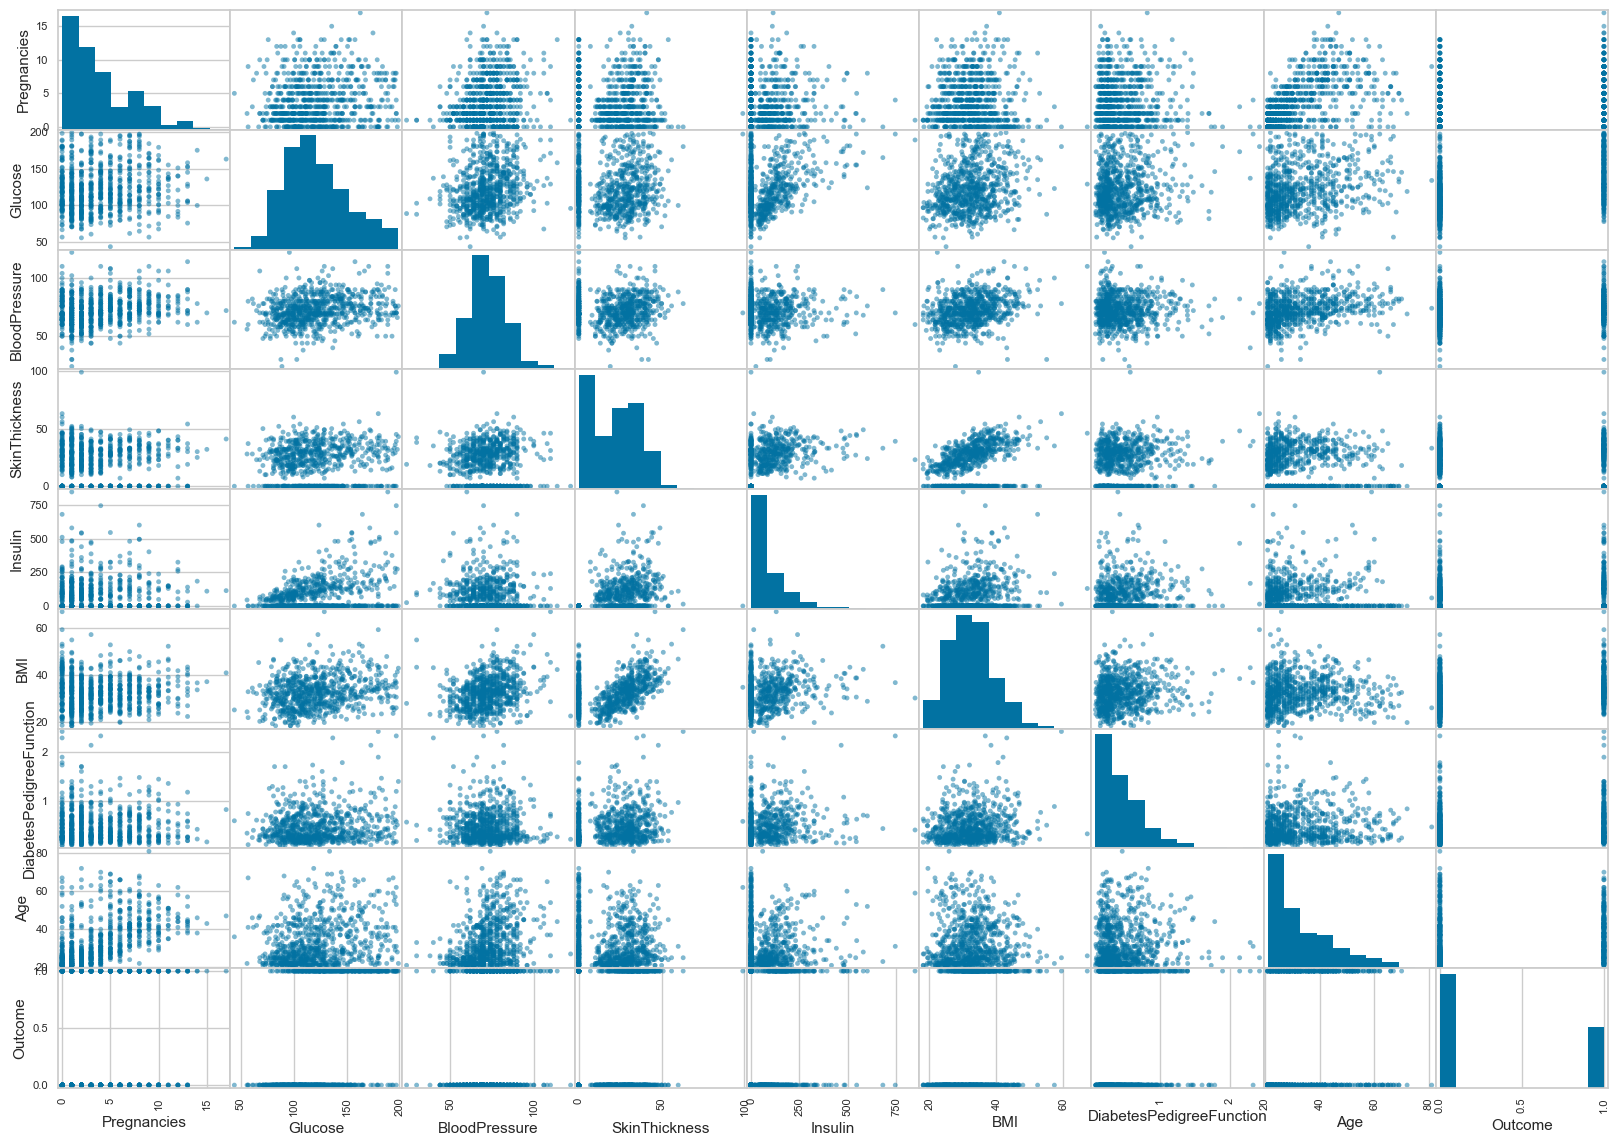

In [9]:
# Generate a scatter plot for all pairs in the features to see if there is correlation.
scatter_matrix(diabetes[diabetes.columns], figsize=(20,14))

It can be seen that some of our findings match the brief research done into the causes of diabetes. Glucose, BMI, Age and Pregnancies all have a good correlation to the target class and are so important to classifying any instance.

I will refrain from doing some feature engineering as I realise this preprocessing section is getting quite verbose and doesn't need anymore padding!

### Section 2.1 - Splitting data

Originally I had planned to do a simple train/test split of the data. Realising that we have only 768 instances, it is very feasible for us to use cross-fold validation in place. This is because a simple train test split doesn't give a great representation of out of sample performance as only a small portion of data is used to test the model trained. Cross-fold validation splits the data into n-folds and trains the model on n-1 folds and tests on the last fold that was left out. This is repeated leaving out a different fold each time until we have n models trained. This is a much better test of how our model will generalize and perform on unseen, out of sample data.

I will carry out both model evaluation methods to compare the performance of both. I suspect that the cross-fold validation score will be a little lower but this is due to the better approxiamtion of performance on out of sample instances. To keep the comparison fair we will consider each model to have the same amount of data to train with. If we have 1 80:20 train/test split we need to have 5 folds to allow the cross-validation models to be trained on 80% of the data.

In [10]:
# Set x as the features without the raget and y as the target class.
x = diabetes.drop("Outcome", axis=1)
y = diabetes.Outcome

# Split the data into a train and test set with a 80:20 split, stratify so the target class is equally distributed.
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)


# Print out the counts of instances with the target classes in both the train and test sets.
print(" 0,  1")
print(unique(y_train, return_counts=True)[1])
print(unique(y_test, return_counts=True)[1])

# Create the function for scoring, we will use the macro F1 score so the classes are both considered equally and not with respect to size.
# Using the micro or weighted f1 will put more weight on the correct predictions of the larger class, in this case no diabetes.
f1 = make_scorer(f1_score , average='macro')

 0,  1
[400 214]
[100  54]


We can see that stratifying the train and test set worked as expected and we have roughlt the same ratio of the target classes in both the train and test set.

### Section 2.2 - Default Random Forest

Now that we have our train and test set we can create our model. We will use the default parameters to get an idea of how a generic random forest performs before optimizing the parameters using GridSearch.

In [ ]:
# Initialise a RandomForestClasifier object.
generic_rf = RandomForestClassifier(random_state=42)

# Fir the data to the model.
generic_rf.fit(X_train, y_train)

# Predict the target class for the test data. We will assess this later on.
test_generic_rf_y_pred = generic_rf.predict(X_test)
print(accuracy_score(test_generic_rf_y_pred, y_test))
print(classification_report(test_generic_rf_y_pred, y_test))
print(confusion_matrix(test_generic_rf_y_pred, y_test))

# Carry out cross-fold validation and output the mean and std of all models macro f1-score.
cross_generic_rf_y_pred = cross_val_score(generic_rf, x, y, cv=5, scoring=f1)
print(cross_generic_rf_y_pred)
print(cross_generic_rf_y_pred.mean(), cross_generic_rf_y_pred.std())

We will wait until we have trained all of our models to compare their results.

### Section 2.3 - Grid Search

Now we will make use of the grid search algorithm to find the combination of parameters that results in the best performance of the model. It has to be mentioned that this is not the most effective method of optimizing parameters, bayesian hyperparameter optimization is more effective. Gridsearch is a less informed search method that only assesses pre-defined parameters by the user. For simplicity however, I will be using grid search to quickly get some (hopefully) better parameters than the default.


In [ ]:
# List of parameters to test out.
params = [{"n_estimators": [50, 100, 150, 200], 
           "max_depth":[1, 2], 
           "min_samples_split": [2, 3, 4], 
           "min_samples_leaf": [1, 2, 3], 
           "max_leaf_nodes": [2, 3, 4], 
           "min_impurity_decrease": [0.0, 0.05, 0.1]}]

# Initialise a RandomForestClassifer object.
clf = RandomForestClassifier(random_state=42)

# Set up the grid search with the classifier, parameter list, scoring function and use all available processing power.
grid_search_rf = GridSearchCV(clf, params, scoring=f1, cv=5, verbose=2, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

In [ ]:
grid_search_rf.best_params_

In [ ]:
print(grid_search_rf.best_score_)

We can see from the results of the grid search that we found the best model from those parameters. Some of those parameters however were at the lower or upper limit of the allowable values. So I will go back and adjust the ranges to allow the parameters more allowable values above or below the limit they reached.

This can be iterated as many times as desired until they converge. As the saying goes, "perfect is the enemy of good". We must not spend all of our time tweaking the parameters until they're absolutely perfect. 

In [ ]:
# List of adjusted parameters to test.
params = [{"n_estimators": [120, 130, 140], 
           "max_depth":[4, 5, 6], 
           "min_samples_split": [1, 2, 3], 
           "min_samples_leaf": [3, 4, 5], 
           "max_leaf_nodes": [9, 10, 11], 
           "min_impurity_decrease": [0.0]}]

# Initialise a RandomForestClassifer object.
clf = RandomForestClassifier(random_state=42)

# Set up the grid search with the classifier, parameter list, scoring function and use all available processing power.
grid_search_rf = GridSearchCV(clf, params, scoring=f1, cv=5, verbose=2, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

In [ ]:
grid_search_rf.best_params_

In [ ]:
print(grid_search_rf.best_score_)

In [ ]:
# Initialise a RandomForestClasifier object.
grid_search_rf = RandomForestClassifier(n_estimators=130, max_depth=5, max_leaf_nodes=11, min_samples_leaf=5, min_samples_split=2)

# Fir the data to the model.
grid_search_rf.fit(X_train, y_train)

# Predict the target class for the test data. We will assess this later on.
test_grid_search_rf_y_pred = grid_search_rf.predict(X_test)
print(accuracy_score(test_grid_search_rf_y_pred, y_test))
print(classification_report(test_grid_search_rf_y_pred, y_test))
print(confusion_matrix(test_grid_search_rf_y_pred, y_test))

cross_generic_rf_y_pred = cross_val_score(grid_search_rf, x, y, cv=5, scoring=f1)
print(cross_generic_rf_y_pred)
print(cross_generic_rf_y_pred.mean(), cross_generic_rf_y_pred.std())

It can be noted that the more we tune the parameters we don't run the risk of overfitting. This is due to the fact that we are using cross validation as a way of determining the best parameter. This means we are generating 5 different modes (as cv=5 in our GridSearch parameters) each trained on 4 of the 5 sets of data and tested on the remaining set. Each of the 5 models is train on a different subset of 4. This means that all 5 models receive some unseen data to predict on and the increase in performance is due to a better set of parameters and not overfitting the training set.

### Section 2.4 - Boosting

Boosting is a method used to generate ensemble models where each successive model learns from the errors made by the previous. For example, an AdaBoost ensemble is generated by first generating a model, say a decision tree. The predictions it makes on the dataset are evaluated, any instances that it incorrectly classified are given more weight in the training of the next classifier in the ensemble. In this way the difficult cases are given more attention and each successive model makes up (hopefully!) for what the previous model lacked.

In [ ]:
# Create an instance of AdaBoost with a decision tree using the parameters we found from gridsearch
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5, max_leaf_nodes=10, min_samples_leaf=4, min_samples_split=2), random_state=42, n_estimators=130, algorithm="SAMME.R", learning_rate=0.01)

# Train the AdaBoost ensemble
ada_clf.fit(X_train, y_train)

# Predict on the test set
ada_y_pred = ada_clf.predict(X_test)
print(accuracy_score(ada_y_pred, y_test))
print(classification_report(ada_y_pred, y_test))
print(confusion_matrix(ada_y_pred, y_test))

cross_ada_y_pred = cross_val_score(ada_clf, x, y, cv=5, scoring=f1)
print(cross_ada_y_pred)
print(cross_ada_y_pred.mean(), cross_ada_y_pred.std())

Now we will look at GradientBoosting, this is a method that optimizes the loss function of several sequential classfiers. This differs to AdaBoosting which gives more weight to the incorrectly classified instances.

In [ ]:
gbc_clf = GradientBoostingClassifier(learning_rate=0.1, n_estimators=130, criterion='friedman_mse', random_state=42, max_depth=5, max_leaf_nodes=10, min_samples_leaf=4, min_samples_split=2)
gbc_clf.fit(X_train, y_train)
test_gbc_y_pred = gbc_clf.predict(X_test)
print(accuracy_score(test_gbc_y_pred, y_test))
print(classification_report(test_gbc_y_pred, y_test))
print(confusion_matrix(test_gbc_y_pred, y_test))

cross_gbc_y_pred = cross_val_score(gbc_clf, x, y, cv=5, scoring=f1)
print(cross_gbc_y_pred)
print(cross_gbc_y_pred.mean(), cross_gbc_y_pred.std())

### Section 2.5 - Results and comparison

Below are the tables with the different performance metrics for each of the trained models.

#### Standard Train/Test split

| Classifier Type                     	| No Diabetes F1-Score| Diabetes F1-Score 	| Macro F1-Score	|
|-------------------------------------	|---------------------|---------------------|------------------	|
| Default Random Forest               	| 0.8                 | 0.6	                | 0.7           	|
| Grid Search Optimized Random Forest   | 0.81                | 0.57	            | 0.69           	|
| AdaBoost Random Forest                | 0.82                | 0.60	            | 0.71           	|
| GradientBoost Random Forest           | 0.81                | 0.63	            | 0.72           	|

#### Cross-fold Validation

| Classifier Type                     	| Mean Macro F1-Score | Standard Deviation of Macro F1-Scores	|
|-------------------------------------	|---------------------|----------------------------------------	|
| Default Random Forest               	| 0.733               | 0.041           	                    |
| Grid Search Optimized Random Forest   | 0.724               | 0.029           	                    |
| AdaBoost Random Forest                | 0.734               | 0.027           	                    |
| GradientBoost Random Forest           | 0.739               | 0.038           	                    |


### Section 3.1 - Running PyCaret model generation

Now to create a PyCaret model, this is a much shorter and easier process. The first steps taken to analyse the data and clean up any artefacts is still important, the cleaning in particular. With that done we can now go straight into model generation.

To do this we use the setup() method from PyCaret with the dataset and the target feature. That's the end of training a model, now we can compare all the different models and determine the best fit.

In [11]:
# Call the PyCaret setup method with the data to preprocess the data.

pycaret_diabetes = setup(diabetes, target="Outcome")

,Description,Value
0,session_id,6192
1,Target,Outcome
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(768, 9)"
5,Missing Values,False
6,Numeric Features,7
7,Categorical Features,1
8,Ordinal Features,False
9,High Cardinality Features,False


The training process for PyCaret is very strightforward from the users side. Under the hood PyCaret carrys out all sorts of preprocessing. Some of the typical operations are listed below:

**Data types inferred** - The data type of each column is inferred so that they can be processed accordingly. We will see an issue with this in our example in a moment.

**Missing Values Addressed** - Any missing or NaN values are imputed as the mean for numeric attributes and constant for the categorical. The default can be changed by changing the numeric_imputation and categorical_imputation parameters.

**Train/Test Split** - We can see that the data has been split into a train and test set. We will also notice that the shape of the data has changed from when we input the data. This is as a result of another pre-processing step.

**Data Normalization** - By enabling the normalize parameter the function will normalize the data using the "z-score" method.

**Data Transformation** - By enabling the transformation parameter the function will transform the data in features to have a rouhgly normal distribution.

**Principal Component Analysis** - By enabling the pca parameter the function will find the principle components of all instances in the dataset to decrease the dimension of the dataset and retain as much information as possible.

**One-Hot Encoding** - This is enabled by default and converts categorical features to several binary features in which only one is positive, which is the original catergorical class of the feature. E.g. [Jazz, Pop, Rock] is all possible features, a feature with "Rock" will be converted to [0, 0, 1], a feature with Pop will be converted to [0, 1, 0] and so on. When we look at the data post processing we will see the error that was made by this preprocessing step.

**Ordinal Encoding** Ordinal features must be encoded different than nominal features. This means they have a natural ordering. These must be defined in the setup function using this "ordinal_features = { ‘column_name’ : [‘low’, ‘medium’, ‘high’] }" and chnage the column name and the values to be converted in the correct natural order.

This is just to name a few different options for pre-processing data. Check out the documentation on their website [here](https://pycaret.readthedocs.io/en/stable/api/classification.html) or these specific elements of the preprocessing [here](https://pycaret.gitbook.io/docs/get-started/preprocessing/data-preparation).

Now that we know roughly what PyCaret does under the hood for pre-processing let us see what it has done to our data.

In [12]:
get_config('X')

,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Pregnancies_0,Pregnancies_1,Pregnancies_10,...,Pregnancies_14,Pregnancies_17,Pregnancies_2,Pregnancies_3,Pregnancies_4,Pregnancies_5,Pregnancies_6,Pregnancies_7,Pregnancies_8,Pregnancies_9
0,148.0,72.0,35.0,0.0,33.599998,0.627,50.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,85.0,66.0,29.0,0.0,26.600000,0.351,31.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,183.0,64.0,0.0,0.0,23.299999,0.672,32.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,89.0,66.0,23.0,94.0,28.100000,0.167,21.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,137.0,40.0,35.0,168.0,43.099998,2.288,33.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,101.0,76.0,48.0,180.0,32.900002,0.171,63.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
764,122.0,70.0,27.0,0.0,36.799999,0.340,27.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
765,121.0,72.0,23.0,112.0,26.200001,0.245,30.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
766,126.0,60.0,0.0,0.0,30.100000,0.349,47.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


It seems that PyCaret has confused the pregnancy feature as a categorical features and one-hot encoded it. This isn't what we would like and has made the data (768, 24) in shape as oppossed to (768, 9). This can be seen in the output from the setup which output the shape of the train and test sets as well as the count of categorical features.

We can go back and specify that pregnancies should be considered a numerical feature. This will be done using **numerical_features=["Pregnancies"]**.

The train and test sets are shape (537, 23) and (231, 23) respectively. This means that the train test split is 70:30, we can change this by using **train_size=0.8** in the arguments for setup.

We should also note that looking down the very long list of parameters output from setup that the train and test sets don#t have the target classes stratified. This means that there may be different ratios of diabetes:no diabetes in the train and test set. We can change this by enabling **data_split_stratify=True**.

We don't need to consider any other preprocessing as we have already addressed outliers, artefacts and imputed them. The data does not need to be scaled due to the architecture of the random forest. 

In [13]:
# Call the PyCaret setup method with the data to preprocess the data and the new arguments.

pycaret_diabetes = setup(diabetes, target="Outcome", numeric_features=["Pregnancies"], train_size=0.8, data_split_stratify=True)

,Description,Value
0,session_id,3137
1,Target,Outcome
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(768, 9)"
5,Missing Values,False
6,Numeric Features,8
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


It can now be seen that the train and test sets have a 80:20 split and are stratified. Pregnancies is now considered a numerical feature as can be seen by the shape of the train and test sets, (614, 8) and (154, 8) respectiveky, so all the issues we had with the pre-preocessing have been addressed. Let us confirm this by once again reviewing the data.

In [ ]:
get_config('X')

That looks to be as expected, so now that we have the data for training and testing as we would like it we can compare how different models perform on it. This is done using the comapre_models() method.

Before we jump straight in to use it we should add the metric we have been using thus far, macro f1-score. We can do this for the current instance by using add_metric('macro_f1', 'Macro F1-Score', f1, greater_is_better = True). This will add it to the list of metrics that we currently have available. We can then sort by this metric to find the model that performs best on both classes.

In [30]:
# Add the Macro F1-Score metric so we can assess the models performance on 

add_metric('MACRO', 'Macro F1-Score', f1_score, greater_is_better = True, average='macro')

metrics = get_metrics()

In [31]:
print(metrics)

                     Name    Display Name  \
ID                                          
acc              Accuracy        Accuracy   
auc                   AUC             AUC   
recall             Recall          Recall   
precision       Precision           Prec.   
f1                     F1              F1   
kappa               Kappa           Kappa   
mcc                   MCC             MCC   
MACRO      Macro F1-Score  Macro F1-Score   

                                              Score Function  \
ID                                                             
acc          <function accuracy_score at 0x0000019D7FE68B80>   
auc           <function roc_auc_score at 0x0000019D7FE629D0>   
recall     <pycaret.internal.metrics.BinaryMulticlassScor...   
precision  <pycaret.internal.metrics.BinaryMulticlassScor...   
f1         <pycaret.internal.metrics.BinaryMulticlassScor...   
kappa      <function cohen_kappa_score at 0x0000019D7FE68...   
mcc        <function matthews_corrcoe

                Name Display Name  \
ID                                  
acc         Accuracy     Accuracy   
auc              AUC          AUC   
recall        Recall       Recall   
precision  Precision        Prec.   
f1                F1           F1   
kappa          Kappa        Kappa   
mcc              MCC          MCC   

                                              Score Function  \
ID                                                             
acc          <function accuracy_score at 0x0000019D7FE68B80>   
auc           <function roc_auc_score at 0x0000019D7FE629D0>   
recall     <pycaret.internal.metrics.BinaryMulticlassScor...   
precision  <pycaret.internal.metrics.BinaryMulticlassScor...   
f1         <pycaret.internal.metrics.BinaryMulticlassScor...   
kappa      <function cohen_kappa_score at 0x0000019D7FE68...   
mcc        <function matthews_corrcoef at 0x0000019D7FE84...   

                                                      Scorer      Target  \
ID           

In [ ]:
best = compare_models(sort='Macro F1-Score')

### Section 3.2 - PyCaret results

4.1 - Manual model creation vs. AutoML methods

In [32]:
best = compare_models(sort='Macro F1-Score')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Macro F1-Score,TT (Sec)
lr,Logistic Regression,0.7770,0.8496,0.5747,0.7350,0.6410,0.4832,0.4935,0.7393,0.6120
ridge,Ridge Classifier,0.7722,0.0000,0.5608,0.7287,0.6294,0.4697,0.4808,0.7322,0.0030
lda,Linear Discriminant Analysis,0.7705,0.8493,0.5654,0.7232,0.6299,0.4679,0.4783,0.7315,0.0040
et,Extra Trees Classifier,0.7671,0.8309,0.5833,0.6991,0.6332,0.4651,0.4711,0.7311,0.0480
nb,Naive Bayes,0.7624,0.8274,0.6175,0.6798,0.6404,0.4649,0.4709,0.7310,0.0030
gbc,Gradient Boosting Classifier,0.7622,0.8429,0.5929,0.6881,0.6288,0.4570,0.4655,0.7263,0.0220
qda,Quadratic Discriminant Analysis,0.7559,0.8257,0.5846,0.6788,0.6231,0.4450,0.4512,0.7209,0.0040
lightgbm,Light Gradient Boosting Machine,0.7509,0.8197,0.5874,0.6709,0.6187,0.4361,0.4438,0.7159,0.0130
rf,Random Forest Classifier,0.7525,0.8247,0.5465,0.6851,0.6042,0.4281,0.4365,0.7119,0.0550
ada,Ada Boost Classifier,0.7460,0.8207,0.5749,0.6606,0.6095,0.4237,0.4296,0.7101,0.0190


### 4.1 - Manual model creation vs. AutoML methods

It can not be understated the different with regard to time it takes to manually train and model and using AutoML to do the same job.